In [4]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(42)

# Simulate daily returns for 3 assets (1000 trading days)
days = 1000
dates = pd.date_range(end=pd.Timestamp.today(), periods=days)

# Mean (drift) and standard deviation (volatility) of returns
mu = np.array([0.0004, 0.0002, 0.0003])
sigma = np.array([0.012, 0.015, 0.02])

# Simulate returns assuming normal distribution
returns = np.random.normal(mu, sigma, size=(days, 3))
assets = ['Asset_A', 'Asset_B', 'Asset_C']

# Convert to DataFrame
returns_df = pd.DataFrame(returns, columns=assets, index=dates)

# Portfolio weights (50%, 30%, 20%)
weights = np.array([0.5, 0.3, 0.2])

# Calculate portfolio returns
returns_df['Portfolio'] = returns_df.dot(weights)

# Portfolio cumulative returns (starting at 100)
returns_df['Portfolio_Value'] = 100 * (1 + returns_df['Portfolio']).cumprod()

returns_df.head()


,Asset_A,Asset_B,Asset_C,Portfolio,Portfolio_Value
2023-02-15 16:37:56.247120,0.006361,-0.001874,0.013254,0.005269,100.526885
2023-02-16 16:37:56.247120,0.018676,-0.003312,-0.004383,0.007468,101.277614
2023-02-17 16:37:56.247120,0.019351,0.011712,-0.009089,0.011371,102.429225
2023-02-18 16:37:56.247120,0.006911,-0.006751,-0.009015,-0.000373,102.391025
2023-02-19 16:37:56.247120,0.003304,-0.028499,-0.034198,-0.013738,100.984412


In [3]:
# Part 2: Market Risk Metrics 

# Portfolio return series
portfolio_returns = returns_df['Portfolio']

# 1. Mean and Volatility
mean_return = portfolio_returns.mean()
volatility = portfolio_returns.std(ddof=1)

# 2. Parametric VaR (99%) assuming normality
z_99 = 2.33  # z-score for 99%
parametric_VaR_99 = -(mean_return - z_99 * volatility)

# 3. Historical VaR (99%)
historical_VaR_99 = -np.quantile(portfolio_returns, 0.01)

# 4. Expected Shortfall (CVaR) - average of worst 1% returns
expected_shortfall_99 = -portfolio_returns[portfolio_returns <= -historical_VaR_99].mean()

# Combine results
market_risk_summary = pd.DataFrame({
    'Metric': ['Mean Daily Return', 'Volatility (σ)', 'Parametric VaR (99%)', 
               'Historical VaR (99%)', 'Expected Shortfall (99%)'],
    'Value': [mean_return, volatility, parametric_VaR_99, historical_VaR_99, expected_shortfall_99]
})

market_risk_summary


,Metric,Value
0,Mean Daily Return,0.000811
1,Volatility (σ),0.008226
2,Parametric VaR (99%),0.018356
3,Historical VaR (99%),0.017513
4,Expected Shortfall (99%),0.020515


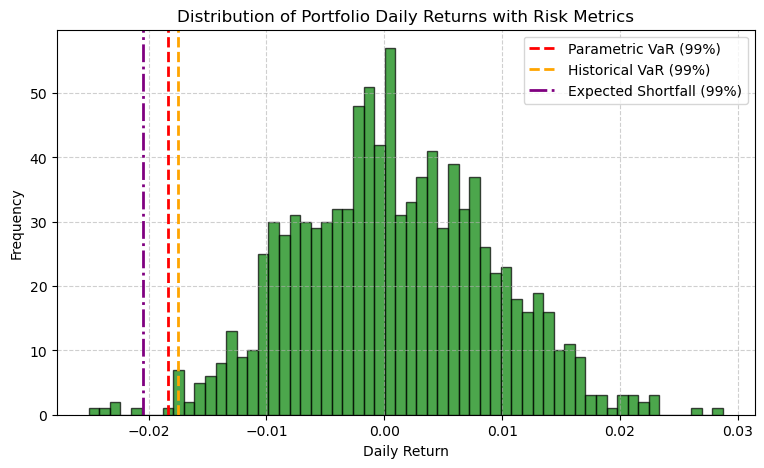

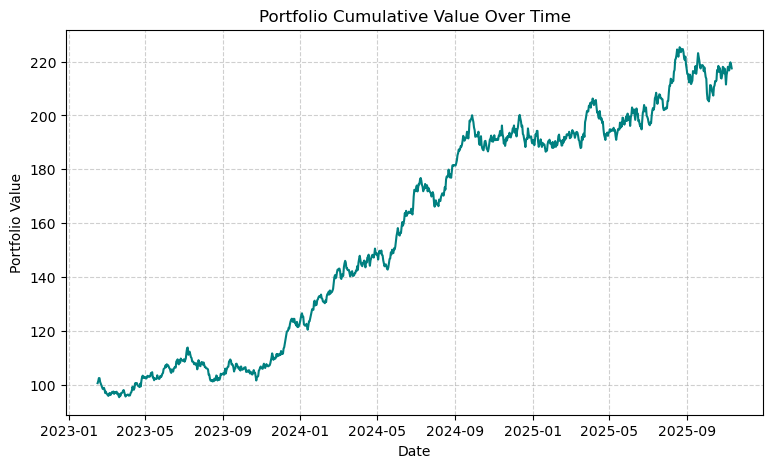

In [15]:
# śPart 3: Visualization 

plt.figure(figsize=(9,5))
plt.hist(portfolio_returns, bins=60, color='green', edgecolor='black', alpha=0.7)
plt.axvline(-parametric_VaR_99, color='red', linestyle='--', linewidth=2, label='Parametric VaR (99%)')
plt.axvline(-historical_VaR_99, color='orange', linestyle='--', linewidth=2, label='Historical VaR (99%)')
plt.axvline(-expected_shortfall_99, color='purple', linestyle='-.', linewidth=2, label='Expected Shortfall (99%)')
plt.title("Distribution of Portfolio Daily Returns with Risk Metrics")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Plot cumulative portfolio value
plt.figure(figsize=(9,5))
plt.plot(returns_df.index, returns_df['Portfolio_Value'], color='teal')
plt.title("Portfolio Cumulative Value Over Time")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [16]:
# Part 4: Stress Testing (Market Shock Scenario) 

# Define stress parameters
stress_days = 250  # roughly one trading year
stress_factor = 3.0  # increase volatility 3x
mean_shift = -0.001  # shift mean downward to simulate losses

# Simulate stressed returns using the same base assets
stressed_returns = np.random.normal(mean_shift, volatility * stress_factor, size=stress_days)
stressed_df = pd.DataFrame(stressed_returns, columns=['Portfolio_Stress'])

# Calculate metrics under stress
stress_mean = stressed_df['Portfolio_Stress'].mean()
stress_vol = stressed_df['Portfolio_Stress'].std()
stress_VaR = -np.quantile(stressed_df['Portfolio_Stress'], 0.01)
stress_ES = -stressed_df['Portfolio_Stress'][stressed_df['Portfolio_Stress'] <= -stress_VaR].mean()

# Combine into comparison table
compare = pd.DataFrame({
    'Metric': ['Mean Return', 'Volatility', 'VaR (99%)', 'Expected Shortfall (99%)'],
    'Normal': [mean_return, volatility, historical_VaR_99, expected_shortfall_99],
    'Stress': [stress_mean, stress_vol, stress_VaR, stress_ES]
})

compare


,Metric,Normal,Stress
0,Mean Return,0.000811,-0.003085
1,Volatility,0.008226,0.025420
2,VaR (99%),0.017513,0.058043
3,Expected Shortfall (99%),0.020515,0.068682
